Downloading the data

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

--2022-06-18 23:39:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 142.251.120.128, 142.251.161.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   189MB/s    in 0.9s    

2022-06-18 23:39:22 (189 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

--2022-06-18 23:39:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request

## Preparing the data
Unzip file

In [2]:
import zipfile

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip','r')
zip_ref.extractall()
zip_ref.close()

train_data_dir = '10_food_classes_10_percent/train/'
validate_dir = '10_food_classes_10_percent/test/'

Loading data into train and validate

In [3]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                                            label_mode='categorical',
                                                                            image_size=(224,224),
                                                                            batch_size=32)

validate_data = tf.keras.preprocessing.image_dataset_from_directory(validate_dir,
                                                                    label_mode='categorical',
                                                                    image_size=(224,224),
                                                                    batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Callbacks

### Create ModelCheckpoint Callbacks

In [4]:
checkpoint_path='checkpoints_weight/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)

In [5]:
# def checkpoint_callback(dir_name,experiment_name):

#   log_dir = dir_name + '/' + experiment_name + '/'
#   checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=log_dir,
#                                                   save_weights_only=True,
#                                                   save_best_only=True,
#                                                   save_freq='epoch',
#                                                   verbose=1)
#   print(f"Saving checkpoint files to: {log_dir}")

#   return checkpoint

### Create Tensorboard Callbacks

In [6]:
import datetime
def tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/'
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard files to: {log_dir}")
  return tensorboard_callback

### Create accuracy callback

In [7]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    percent = percent/100
    if(logs.get('accuracy')>percent):
      print(f"\nReached {percent} accuracy so cancelling training!")
      self.model.stop_training = True

callback = myCallback

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      # preprocessing.Rescaling(1./255.) # some model need to rescaling
], name='data_augmentation_layer')


## Model #0

In [9]:
# Create base model or backbone
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outpus
inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)

# Change into feature vector by using GlobalAveragePooling
x = layers.GlobalAveragePooling2D(name='Global_Average_Pooling')(x)

outputs = layers.Dense(10,activation='softmax',name='output_layer')(x)

model_0 = tf.keras.Model(inputs,outputs)

model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_0.summary()



16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                              

In [10]:
history_0 = model_0.fit(train_data,
                        validation_data=validate_data,
                        epochs=5,
                        validation_steps=int(0.25*len(validate_data)),
                        callbacks=[tensorboard_callback('transfer_learning','model_0'),
                                   checkpoint_callback,
                                   ])

Saving TensorBoard files to: transfer_learning/model_0/
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0076 - accuracy: 0.3293
Epoch 1: val_loss improved from inf to 1.49862, saving model to checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 33s 654ms/step - loss: 2.0076 - accuracy: 0.3293 - val_loss: 1.4986 - val_accuracy: 0.6382
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3760 - accuracy: 0.6640
Epoch 2: val_loss improved from 1.49862 to 1.07093, saving model to checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 10s 416ms/step - loss: 1.3760 - accuracy: 0.6640 - val_loss: 1.0709 - val_accuracy: 0.7747
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0694 - accuracy: 0.7307
Epoch 3: val_loss improved from 1.07093 to 0.88492, saving model to checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 10s 399ms/step - loss: 1.0694 - accuracy: 0.7307 - val_

In [11]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot Loss
  plt.figure(figsize=(10,7))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot Accuracy
  plt.figure(figsize=(10,7))
  plt.plot(epochs, accuracy, label='Accuracy')
  plt.plot(epochs, val_accuracy, label='Validatio Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

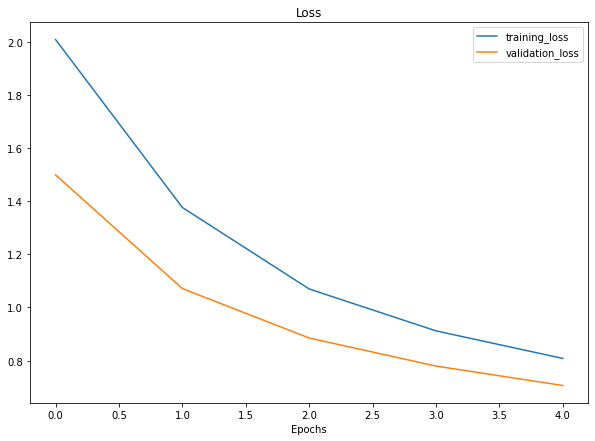

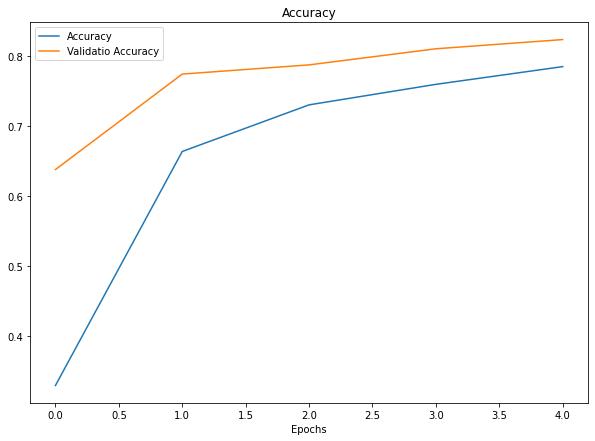

In [12]:
plot_loss_curves(history_0)

In [13]:
evaluate_0 = model_0.evaluate(validate_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.6865 - accuracy: 0.8212


## Model #1

Fine tune of model #0

In [14]:
for layer in model_0.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1a0dc837d0> True
<keras.engine.sequential.Sequential object at 0x7f1a0c71ec10> True
<keras.engine.functional.Functional object at 0x7f198e244890> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f198e216410> True
<keras.layers.core.dense.Dense object at 0x7f1a0e3168d0> True


In [15]:
print(type(model_0.layers))

<class 'list'>


### Begin Fine-Tuning the last 20 layers of the best model

In [16]:
# Set the base_model_1 to True
base_model.trainable = True

# Free all layers except for the last 10
for layer in base_model.layers[:-20]:
  layer.trainable = False

model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

for i, layer in (enumerate(model_0.layers[2].layers)):
  print(i, layer.name, layer.trainable)


0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [17]:
print(len(model_0.trainable_variables))

21


In [18]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 1,363,770
Non-train

In [19]:
history_1 = model_0.fit(train_data,
                        epochs=20,
                        validation_data=validate_data,
                        validation_steps=int(0.25*(len(validate_data))),
                        initial_epoch=history_0.epoch[-1],
                        callbacks=[tensorboard_callback('transfer_learning','model_1'),
                                   checkpoint_callback,
                                   ])

Saving TensorBoard files to: transfer_learning/model_1/
Epoch 5/20
24/24 [==============================] - ETA: 0s - loss: 0.7609 - accuracy: 0.7613
Epoch 5: val_loss improved from 0.70632 to 0.68472, saving model to checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 21s 526ms/step - loss: 0.7609 - accuracy: 0.7613 - val_loss: 0.6847 - val_accuracy: 0.7697
Epoch 6/20
24/24 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.8733
Epoch 6: val_loss improved from 0.68472 to 0.58909, saving model to checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 9s 340ms/step - loss: 0.3728 - accuracy: 0.8733 - val_loss: 0.5891 - val_accuracy: 0.8372
Epoch 7/20
24/24 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9253
Epoch 7: val_loss improved from 0.58909 to 0.53505, saving model to checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 9s 344ms/step - loss: 0.2224 - accuracy: 0.9253 -

In [20]:
evaluate_1 = model_0.evaluate(validate_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6021 - accuracy: 0.8492


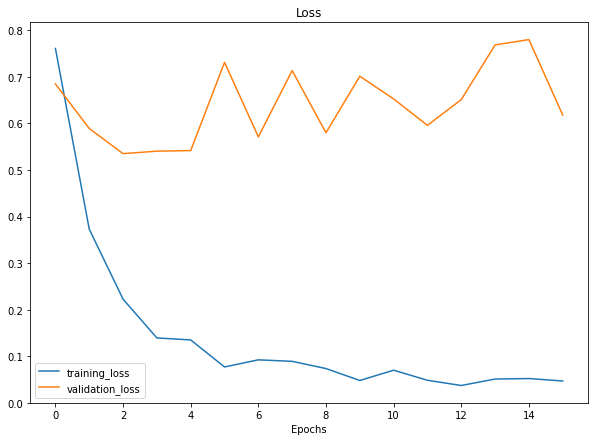

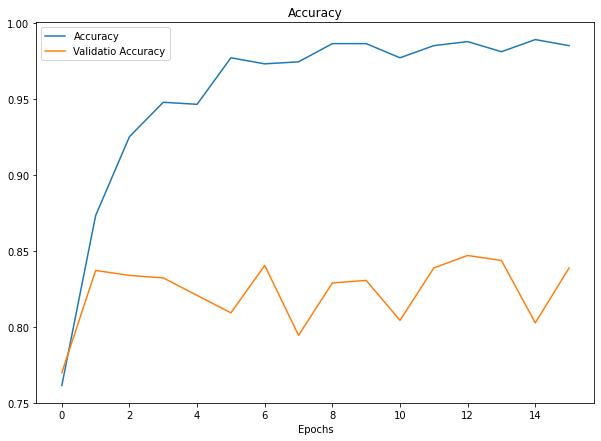

In [21]:
plot_loss_curves(history_1)

## Model #2

In [22]:
for layer in model_0.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1a0dc837d0> True
<keras.engine.sequential.Sequential object at 0x7f1a0c71ec10> True
<keras.engine.functional.Functional object at 0x7f198e244890> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f198e216410> True
<keras.layers.core.dense.Dense object at 0x7f1a0e3168d0> True


In [23]:
# Set the base model to True
base_model.trainable = True

# Free all layers except for the last 30 layers
for layer in base_model.layers[:-30]:
  layer.trainable = False

model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

for i, layer in enumerate(model_0.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [24]:
print(len(model_0.trainable_variables))

30


In [25]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 1,508,970
Non-train

In [26]:
history_2 = model_0.fit(train_data,
                        validation_data=validate_data,
                        epochs=30,
                        validation_steps=int(0.25*len(validate_data)),
                        initial_epoch=history_1.epoch[-1],
                        callbacks=[tensorboard_callback('transfer_learning','model_1'),
                                   checkpoint_callback,
                                   ])

Saving TensorBoard files to: transfer_learning/model_1/
Epoch 20/30
24/24 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9707
Epoch 20: val_loss did not improve from 0.53505
24/24 [==============================] - 15s 352ms/step - loss: 0.0960 - accuracy: 0.9707 - val_loss: 0.7211 - val_accuracy: 0.8174
Epoch 21/30
24/24 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9800
Epoch 21: val_loss did not improve from 0.53505
24/24 [==============================] - 7s 299ms/step - loss: 0.0568 - accuracy: 0.9800 - val_loss: 0.9089 - val_accuracy: 0.8224
Epoch 22/30
24/24 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9773
Epoch 22: val_loss did not improve from 0.53505
24/24 [==============================] - 7s 267ms/step - loss: 0.0645 - accuracy: 0.9773 - val_loss: 0.6427 - val_accuracy: 0.8322
Epoch 23/30
24/24 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9840
Epoch 23: val_loss did not

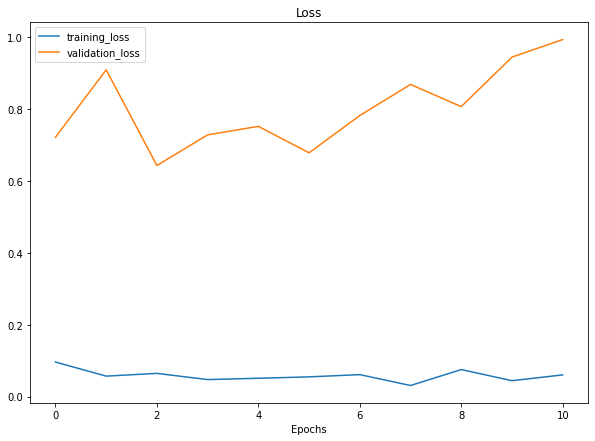

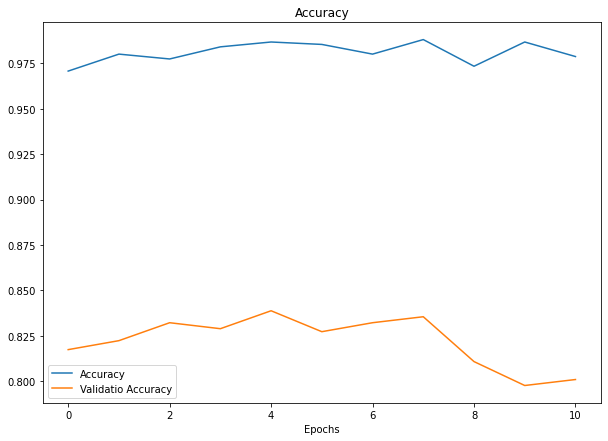

In [27]:
plot_loss_curves(history_2)

In [28]:
evaluate_2 = model_0.evaluate(validate_data)

79/79 [==============================] - 6s 72ms/step - loss: 1.0940 - accuracy: 0.7912


## Extra - Visualize image

In [37]:
import numpy as np
class_names = train_data.class_names

In [38]:
# Creating a function that would grab the image from a dataset, visualize and gives the prediction of it. 

def dataset_visualizer(dataset , model):
  '''
  Arguments: 
    dataset --> `tf.data.Dataset` object with (image , label) tuples 
    model --> the trained model 

  Returns: 
    Visualizae the image from the dataset and the prediction class of the image. 
  '''
  
  image_batch , label_batch = dataset.as_numpy_iterator().next() 
  batch_prob = [model.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2 , 2 , i + 1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}" , c = title_color)
    plt.axis('off')

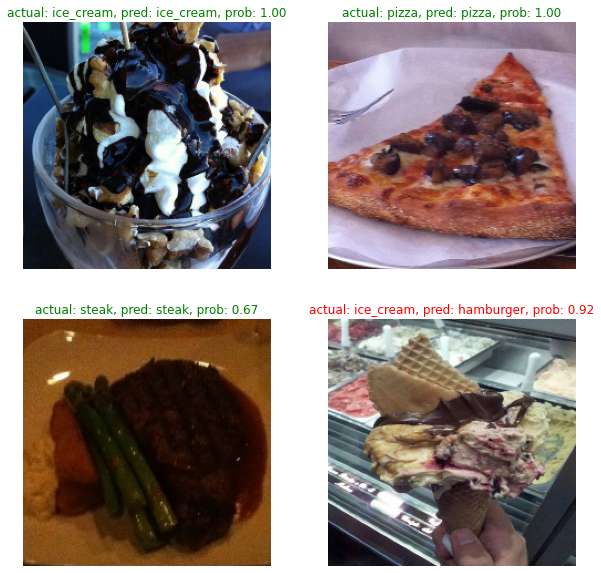

In [39]:
dataset_visualizer(validate_data, model_0)